In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# ------------------------------
# 1. Load CMAPSS Dataset
# ------------------------------
cmapss_dir = "../data/raw/CMAPSS/"
train_file = os.path.join(cmapss_dir, "train_FD001.txt")
test_file = os.path.join(cmapss_dir, "test_FD001.txt")
rul_file = os.path.join(cmapss_dir, "RUL_FD001.txt")

# Column names based on CMAPSS documentation
col_names = ['unit_number', 'time_in_cycles',
             'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
            [f'sensor_{i}' for i in range(1,22)]

# Load training data
train_FD001 = pd.read_csv(train_file, sep=" ", header=None)
train_FD001 = train_FD001.dropna(axis=1, how='all')  # remove empty columns
train_FD001.columns = col_names

print("CMAPSS Training Data (FD001):")
print(train_FD001.head())
print(f"Shape: {train_FD001.shape}")

CMAPSS Training Data (FD001):
   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4                  100.0    518.67    642.37   1582.85   1406.22     14.62   

   ...  sensor_12  s

In [3]:
# Generate RUL function
def generate_rul(df):
    rul = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    rul.columns = ['unit_number', 'max_cycle']
    df = df.merge(rul, on='unit_number', how='left')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    return df

# Apply RUL generation
train_FD001 = generate_rul(train_FD001)

# Feature selection (based on literature/domain knowledge)
selected_features = ['unit_number','time_in_cycles','RUL',
                     'operational_setting_1','operational_setting_2','operational_setting_3',
                     'sensor_2','sensor_3','sensor_4','sensor_7','sensor_8',
                     'sensor_11','sensor_12','sensor_15','sensor_17','sensor_20']

train_FD001 = train_FD001[selected_features]

# Cap RUL at maximum value
MAX_RUL = 125
max_cycles = train_FD001.groupby("unit_number")["time_in_cycles"].max().reset_index()
max_cycles.columns = ["unit_number", "max_cycle"]
train_FD001 = train_FD001.merge(max_cycles, on="unit_number", how="left")
train_FD001["RUL"] = train_FD001["max_cycle"] - train_FD001["time_in_cycles"]
train_FD001["RUL"] = train_FD001["RUL"].clip(upper=MAX_RUL)
train_FD001.drop(columns=["max_cycle"], inplace=True)

print("CMAPSS data with RUL:")
print(train_FD001[["unit_number","time_in_cycles","RUL"]].head())

CMAPSS data with RUL:
   unit_number  time_in_cycles  RUL
0            1               1  125
1            1               2  125
2            1               3  125
3            1               4  125
4            1               5  125


In [4]:
# Split data by unit numbers for proper train/validation split
unit_numbers = train_FD001['unit_number'].unique()
train_units, val_units = train_test_split(unit_numbers, test_size=0.2, random_state=42)

cmapss_train = train_FD001[train_FD001['unit_number'].isin(train_units)].copy()
cmapss_val = train_FD001[train_FD001['unit_number'].isin(val_units)].copy()

print(f"Training units: {len(train_units)}, Validation units: {len(val_units)}")
print(f"Training samples: {len(cmapss_train)}, Validation samples: {len(cmapss_val)}")

# Scale features
scaler = StandardScaler()
cols_to_scale = [c for c in cmapss_train.columns if c not in ['unit_number','time_in_cycles','RUL']]

cmapss_train[cols_to_scale] = scaler.fit_transform(cmapss_train[cols_to_scale])
cmapss_val[cols_to_scale] = scaler.transform(cmapss_val[cols_to_scale])

print("Scaling completed")

Training units: 80, Validation units: 20
Training samples: 16561, Validation samples: 4070
Scaling completed


In [5]:
# Prepare CMAPSS train/test
X_train_cmapss = cmapss_train.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y_train_cmapss = cmapss_train['RUL']
X_val_cmapss = cmapss_val.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y_val_cmapss = cmapss_val['RUL']

# DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_cmapss, label=y_train_cmapss)
dval = xgb.DMatrix(X_val_cmapss, label=y_val_cmapss)

# XGBoost parameters
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse"
}

# Train model
model_xgb = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, "Validation")], verbose_eval=50)

# Predictions and evaluation
y_pred_xgb = model_xgb.predict(dval)
rmse_xgb = np.sqrt(mean_squared_error(y_val_cmapss, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val_cmapss, y_pred_xgb)

print(f"CMAPSS XGBoost → RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")

[0]	Validation-rmse:38.75104
[50]	Validation-rmse:19.93488
[100]	Validation-rmse:19.98000
[150]	Validation-rmse:20.07826
[199]	Validation-rmse:20.19397
CMAPSS XGBoost → RMSE: 20.19, MAE: 14.98


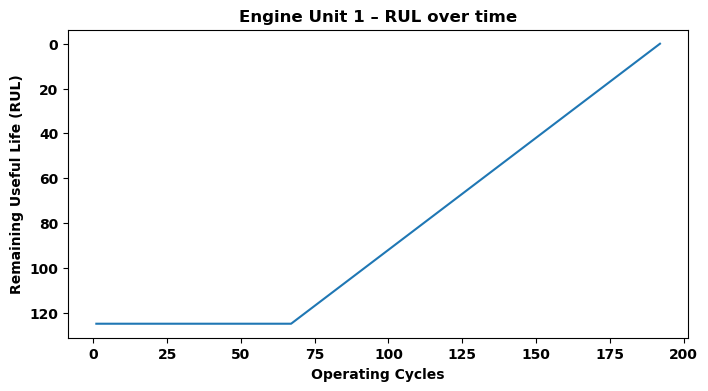

In [6]:
# Plot RUL for one engine unit
unit1 = train_FD001[train_FD001['unit_number'] == 1]

plt.figure(figsize=(8,4))
plt.plot(unit1['time_in_cycles'], unit1['RUL'])
plt.xlabel("Operating Cycles")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Engine Unit 1 – RUL over time")
plt.gca().invert_yaxis()  # RUL decreases with cycles
plt.show()

In [7]:
# ------------------------------
# PRONOSTIA Dataset
# ------------------------------
print("\n" + "="*50)
print("PRONOSTIA DATASET PROCESSING")
print("="*50)

pronostia_dir = "../data/raw/PRONOSTIA/Learning_set/Bearing1_1/"

# Example: load first vibration file
acc_file = os.path.join(pronostia_dir, "acc_00001.csv")
df_acc = pd.read_csv(acc_file, header=None)
df_acc.columns = ["Hour", "Minute", "Second", "Microsecond", "Horiz_accel", "Vert_accel"]

print("PRONOSTIA Vibration Data:")
print("Shape:", df_acc.shape)
print(df_acc.head())


PRONOSTIA DATASET PROCESSING
PRONOSTIA Vibration Data:
Shape: (2560, 6)
   Hour  Minute  Second  Microsecond  Horiz_accel  Vert_accel
0     9      39      39      65664.0        0.552      -0.146
1     9      39      39      65703.0        0.501      -0.480
2     9      39      39      65742.0        0.138       0.435
3     9      39      39      65781.0       -0.423       0.240
4     9      39      39      65820.0       -0.802       0.020


In [8]:
from scipy.stats import skew, entropy
from scipy.fft import fft
import pywt

def fft_band_energy(signal, fs=25600, bands=[(0,1000),(1000,5000),(5000,10000)]):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    fft_vals = np.abs(fft(signal))**2
    energies = []
    for (low, high) in bands:
        mask = (freqs >= low) & (freqs < high)
        energies.append(fft_vals[mask].sum())
    return energies

def extract_features_from_file(file_path):
    df = pd.read_csv(file_path, header=None)
    df.columns = ["Hour","Minute","Second","Microsecond","Horiz_accel","Vert_accel"]

    feats = {}
    for axis in ["Horiz_accel","Vert_accel"]:
        signal = df[axis].values

        # Statistical features
        feats[f"RMS_{axis}"] = np.sqrt(np.mean(signal**2))
        feats[f"Kurtosis_{axis}"] = pd.Series(signal).kurt()
        feats[f"Skew_{axis}"] = skew(signal)
        feats[f"Entropy_{axis}"] = entropy(np.abs(signal)+1e-10)
        feats[f"CrestFactor_{axis}"] = np.max(np.abs(signal)) / (np.sqrt(np.mean(signal**2)) + 1e-8)

        # FFT energy bands
        energies = fft_band_energy(signal)
        for i, e in enumerate(energies):
            feats[f"FFTband{i+1}_{axis}"] = e

        # Wavelet transform features
        coeffs = pywt.wavedec(signal, 'db4', level=3)
        for i, c in enumerate(coeffs):
            feats[f"WaveletEnergy_L{i}_{axis}"] = np.sum(np.square(c))

    return feats

# Test feature extraction
features = extract_features_from_file("../data/raw/PRONOSTIA/Learning_set/Bearing1_1/acc_00001.csv")
print("Extracted features from first file:")
print(features)

Extracted features from first file:
{'RMS_Horiz_accel': 0.56174565773522, 'Kurtosis_Horiz_accel': -0.12937474006868177, 'Skew_Horiz_accel': -0.00471106707861808, 'Entropy_Horiz_accel': 7.57022023674449, 'CrestFactor_Horiz_accel': 3.578131733714442, 'FFTband1_Horiz_accel': 37083.51493439176, 'FFTband2_Horiz_accel': 869153.3344227525, 'FFTband3_Horiz_accel': 114883.20050989074, 'WaveletEnergy_L0_Horiz_accel': 67.03696529217166, 'WaveletEnergy_L1_Horiz_accel': 214.5481590210491, 'WaveletEnergy_L2_Horiz_accel': 474.50990935693153, 'WaveletEnergy_L3_Horiz_accel': 62.0653355271985, 'RMS_Vert_accel': 0.4358014232064301, 'Kurtosis_Vert_accel': -0.03280164198939506, 'Skew_Vert_accel': 0.002713478645300573, 'Entropy_Vert_accel': 7.567291891876442, 'CrestFactor_Vert_accel': 3.650745221956111, 'FFTband1_Vert_accel': 7805.077258900104, 'FFTband2_Vert_accel': 216309.71546160986, 'FFTband3_Vert_accel': 280148.6176315835, 'WaveletEnergy_L0_Vert_accel': 13.06880721165085, 'WaveletEnergy_L1_Vert_accel':

In [9]:
def process_bearing_folder(bearing_dir, out_path):
    records = []
    for fname in sorted(os.listdir(bearing_dir)):
        if fname.startswith("acc_") and fname.endswith(".csv"):
            fpath = os.path.join(bearing_dir, fname)
            feats = extract_features_from_file(fpath)
            feats["file"] = fname
            records.append(feats)
    
    df = pd.DataFrame(records)
    max_idx = len(df)
    df["RUL"] = list(range(max_idx-1, -1, -1))
    df["label"] = 0
    df.loc[df["RUL"] < max_idx*0.2, "label"] = 1
    
    # Smooth features with rolling window
    df = df.rolling(window=5, min_periods=1).mean()
    
    df.to_csv(out_path, index=False)
    print(f"Processed and saved {out_path}")
    return df

# Process all bearing folders
base_dir = "../data/raw/PRONOSTIA/Learning_set/"
out_dir = "../data/processed/"

# Create output directory if it doesn't exist
os.makedirs(out_dir, exist_ok=True)

all_bearings = []
for bearing_folder in os.listdir(base_dir):
    bpath = os.path.join(base_dir, bearing_folder)
    if os.path.isdir(bpath):
        out_path = os.path.join(out_dir, f"{bearing_folder}.csv")
        df_bearing = process_bearing_folder(bpath, out_path)
        df_bearing["bearing_id"] = bearing_folder
        all_bearings.append(df_bearing)

# Combine all bearings
if all_bearings:
    features_df = pd.concat(all_bearings, ignore_index=True)
    print(f"Combined PRONOSTIA data shape: {features_df.shape}")
    print(f"Unique bearings: {features_df['bearing_id'].unique()}")

C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()


Processed and saved ../data/processed/Bearing1_1.csv


C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()


Processed and saved ../data/processed/Bearing1_2.csv


C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()


Processed and saved ../data/processed/Bearing2_1.csv


C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()


Processed and saved ../data/processed/Bearing2_2.csv


C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()


Processed and saved ../data/processed/Bearing3_1.csv
Processed and saved ../data/processed/Bearing3_2.csv
Combined PRONOSTIA data shape: (7534, 27)
Unique bearings: ['Bearing1_1' 'Bearing1_2' 'Bearing2_1' 'Bearing2_2' 'Bearing3_1'
 'Bearing3_2']


C:\Users\Blue\AppData\Local\Temp\ipykernel_9596\1679949701.py:17: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['file'], dtype='object')
  df = df.rolling(window=5, min_periods=1).mean()
